# Clustering with Annealing

This tutorial will cover clustering using PyQUBO and Openjij as an example for an application of annealing.

## Clustering
Assuming $n$ is given externally, we divide the given data into $n$ clusters. Let us consider 2 clusters in this case.

### Clustering Hamiltonian
Clustering can be done by minimizing the following Hamiltonian:

$$
H = - \sum_{i, j} \frac{1}{2}d_{i,j} (1 - \sigma _i \sigma_j)
$$

$i, j$ is the sample number, $d_{i,j}$ is the distance between the two samples, and $\sigma_i=\{-1,1\}$ is a spin variable that indicates which of the two clusters it belongs to.
Each term of this Hamiltonian sum is:

- 0 when $\sigma_i = \sigma_j $
- $d_{i,j}$  when $\sigma_i \neq \sigma_j $

With the negative on the right-hand side of the Hamiltonian, the entire Hamiltonian comes down to the question to choose the pair of $\{\sigma _1, \sigma _2 \ldots \}$ that maximizes the distance between samples belonging to different classes.

### Import Libraries
We use JijModeling for modeling and JijModeling Transpiler for QUBO generation.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix

import openjij as oj
import jijmodeling as jm
from jijmodeling.transpiler.pyqubo.to_pyqubo import to_pyqubo

### Clustering with JijModeling and OpenJij

First, we formulate the above Hamiltonian using JijModeling.
Since JijModeling cannot handle the spin variable $\sigma_i$, we rewrite it using the relation $\sigma_i = 2x_i - 1$ so that it can be written in the binary variable $x_i$.

In [3]:
problem = jm.Problem("clustering")
d = jm.Placeholder("d", dim=2)
N = d.shape[0].set_latex("N")
x = jm.Binary("x", shape=(N))
i = jm.Element("i", (0, N))
j = jm.Element("j", (0, N))
problem += (
    -1 / 2 * jm.Sum([i, j], d[i, j] * (1 - (2 * x[i] - 1) * (2 * x[j] - 1)))
)
problem

### Generating Artificial Data
Let us artificially generate data that is linearly separable on a 2D plane.

In [4]:
data = []
label = []
for i in range(100):
    # Generate random numbers in [0, 1]
    p = np.random.uniform(0, 1)
    # Class 1 when a condition is satisfied, -1 when it is not.
    cls =1 if p>0.5 else -1
    # Create random numbers that follow a normal distribution
    data.append(np.random.normal(0, 0.5, 2) + np.array([cls, cls]))
    label.append(cls)
# Format as a DataFrame
df1 = pd.DataFrame(data, columns=["x", "y"], index=range(len(data)))
df1["label"] = label

<AxesSubplot: xlabel='x', ylabel='y'>

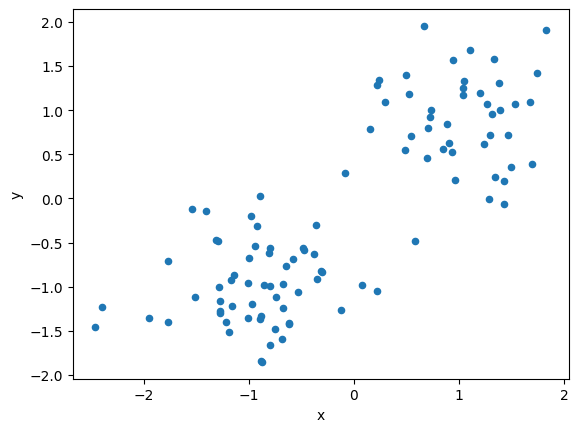

In [5]:
# Visualize dataset
df1.plot(kind='scatter', x="x", y="y")

In [6]:
instance_data = {'d':distance_matrix(df1, df1)}

## Solving the Clustering Problem using OpenJij
With the mathematical model and data, let us start solving the problem by Openjij.
Here we use JijModeling Transpiler.

In [7]:
pyq_obj, pyq_cache = to_pyqubo(problem, instance_data, {})
qubo, constant = pyq_obj.compile().to_qubo()
sampler = oj.SASampler()
response = sampler.sample_qubo(qubo)
result = pyq_cache.decode(response)

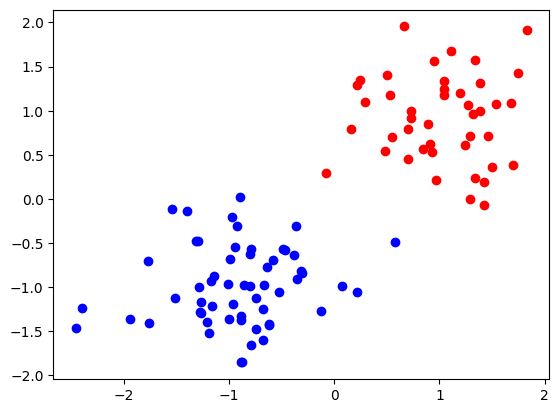

In [8]:
# visualize
for idx in range(0, len(instance_data['d'])):
    if idx in result.record.solution["x"][0][0][0]:
        plt.scatter(df1.loc[idx]["x"], df1.loc[idx]["y"], color="b")
    else:
        plt.scatter(df1.loc[idx]["x"], df1.loc[idx]["y"], color="r")

We see that they are classified into red and blue classes.